In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.7":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.7":
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.18.5", 'matplotlib': "3.2.2",'sklearn': "0.23.1", 
                'pandas': "1.0.5",'xgboost': "1.1.1", 'shap': "0.35.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]

[ OK ] numpy version 1.18.5 is installed.
[ OK ] matplotlib version 3.2.2 is installed.
[ OK ] sklearn version 0.23.1 is installed.
[ OK ] pandas version 1.0.5 is installed.
[ OK ] xgboost version 1.1.1 is installed.
[ OK ] shap version 0.35.0 is installed.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [6]:
df = pd.read_csv('../data/census_tracts.csv')
df = df.drop(columns = ['name'])
df = df.drop(columns = ['metro_area'])
df.head()

,geoid,total_population,total_population_25_over,median_income,median_home_value,educational_attainment,white_alone,black_alone,native_alone,asian_alone,native_hawaiian_pacific_islander,some_other_race_alone,two_or_more,hispanic_or_latino,city
0,11001007503,2454,1425.0,26250.0,345600.0,308.0,122.0,2278.0,0.0,0.0,0.0,0.0,17.0,37.0,Washington
1,11001007601,4855,3463.0,34840.0,255000.0,727.0,311.0,4292.0,0.0,0.0,13.0,0.0,41.0,198.0,Washington
2,11001007709,2524,1817.0,33750.0,250000.0,344.0,20.0,2280.0,0.0,0.0,0.0,0.0,130.0,94.0,Washington
3,11001009508,3691,2838.0,56404.0,356600.0,1008.0,211.0,2688.0,68.0,71.0,0.0,0.0,66.0,587.0,Washington
4,11001009904,2979,1526.0,30728.0,298600.0,252.0,52.0,2375.0,0.0,0.0,15.0,0.0,46.0,491.0,Washington


In [7]:
df = df[df['median_home_value'] != -666666666]
df = df[df['median_income'] != -666666666]

In [8]:
df.shape

(7936, 15)

# EDA

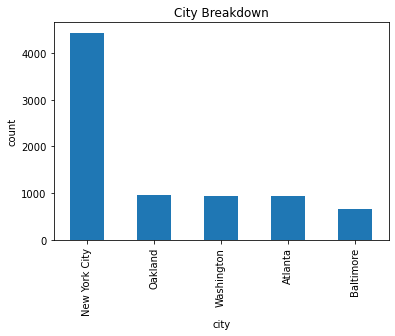

In [9]:
pd.value_counts(df['city']).plot.bar() #can i break this out by city 
plt.ylabel('count')
plt.xlabel('city')
plt.title('City Breakdown')
plt.savefig("../figures/city_breakdown.png", dpi = 300, bbox_inches='tight')
plt.show()

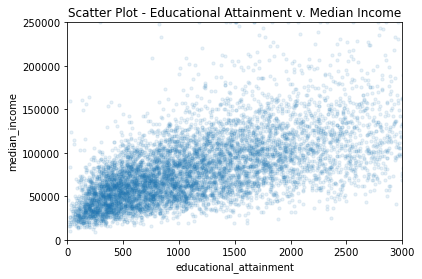

In [11]:
df.plot.scatter('educational_attainment','median_income',s=10,alpha=0.1) # alpha=0.1,s=10
plt.xlim(0, 3000)
plt.ylim(0, 250000)
plt.title('Scatter Plot - Educational Attainment v. Median Income')
plt.savefig("../figures/educational_attainment_scatter.png", dpi = 300, bbox_inches='tight')
plt.show()

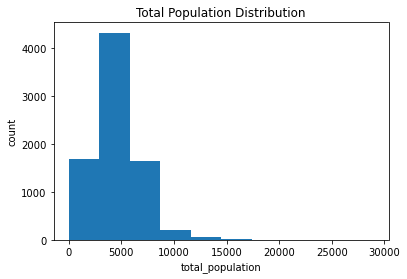

In [12]:
df['total_population'].plot.hist()   
plt.xlabel('total_population')
plt.ylabel('count')
plt.title('Total Population Distribution')
plt.savefig("../figures/total_population_distribution.png", dpi = 300, bbox_inches='tight')
plt.show() 

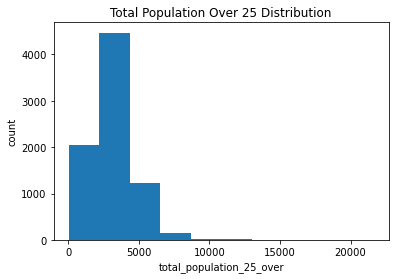

In [13]:
df['total_population_25_over'].plot.hist()   
plt.xlabel('total_population_25_over')
plt.title('Total Population Over 25 Distribution')
plt.ylabel('count')
plt.savefig("../figures/total_population_over_25_distribution.png", dpi = 300, bbox_inches='tight')
plt.show()

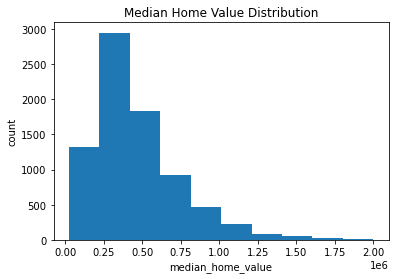

In [14]:
df['median_home_value'].plot.hist(range=[25000, 2_000_000], bins = 10)
plt.xlabel('median_home_value')
plt.ylabel('count')
plt.title('Median Home Value Distribution')
plt.savefig("../figures/median_home_value_distribution.png", dpi = 300, bbox_inches='tight')
plt.show() 

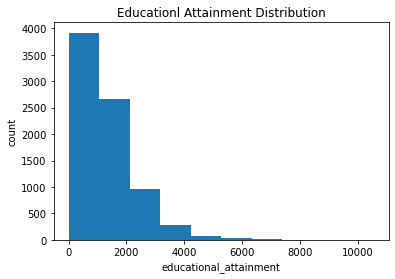

In [15]:
df['educational_attainment'].plot.hist()   
plt.xlabel('educational_attainment')
plt.ylabel('count')
plt.title('Educationl Attainment Distribution')
plt.savefig("../figures/educational_attainment_distribution.png", dpi = 300, bbox_inches='tight')
plt.show()

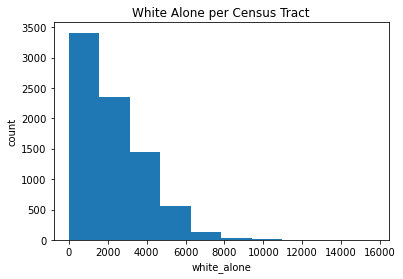

In [16]:
df['white_alone'].plot.hist()   
plt.xlabel('white_alone')
plt.ylabel('count')
plt.title('White Alone per Census Tract')
plt.savefig("../figures/white_alone_per_census_tract.png", dpi = 300, bbox_inches='tight')
plt.show()

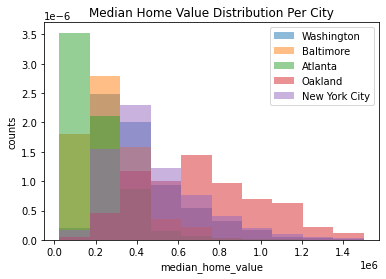

In [17]:
categories = df['city'].unique()
bin_range = (df['median_home_value'].min(),df['median_home_value'].max())

for c in categories:
    plt.hist(df[df['city']==c]['median_home_value'],alpha=0.5,label=c,range=[25000, 1_500_000],density=True)
plt.legend()
plt.ylabel('counts')
plt.xlabel('median_home_value')
plt.title('Median Home Value Distribution Per City')
plt.savefig("../figures/median_home_value_per_city.png", dpi = 300, bbox_inches='tight')
plt.show()

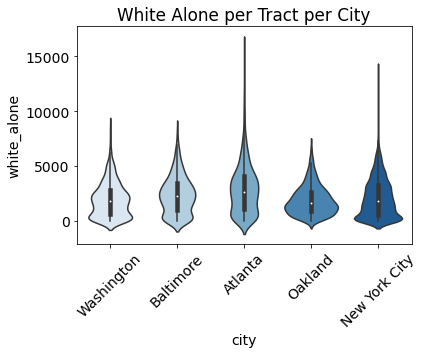

In [38]:
sns.violinplot(x=df["city"], y=df["white_alone"], palette="Blues")
plt.xticks(rotation=45)
plt.title('White Alone per Tract per City')
plt.savefig("../figures/white_alone_violin_plot.png", dpi = 300, bbox_inches='tight')
plt.show()

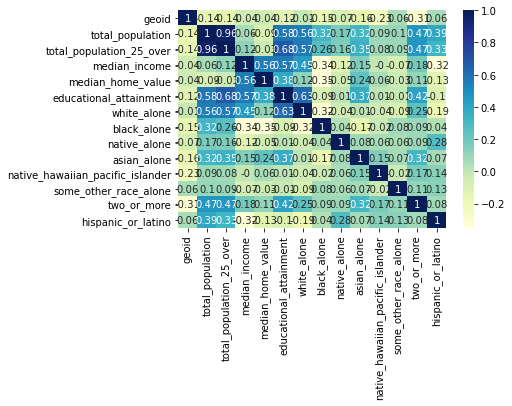

In [22]:
correlation_matrix = df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='YlGnBu')
plt.savefig("../figures/linearity_heat_map.png", dpi = 300)

# Preprocessing and Splitting 

In [31]:
y = df['median_home_value']
X = df.loc[:, df.columns != 'median_home_value'] 

In [32]:
for i in range(10):
    random_state = 42 * i
    
    # split the data
    X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.8, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.2, random_state=random_state)
    
    
    std_ftrs = ['total_population', 'total_population_25_over', 'median_income',
                'educational_attainment', 'white_alone', 'black_alone', 'native_alone', 'asian_alone',
                'native_hawaiian_pacific_islander', 'some_other_race_alone', 'two_or_more', 'hispanic_or_latino']
    
    std_scaler = StandardScaler()
    std_fit = std_scaler.fit(X_train[std_ftrs])
    std_train = std_scaler.transform(X_train[std_ftrs])
    std_val = std_scaler.transform(X_val[std_ftrs])
    std_test = std_scaler.transform(X_test[std_ftrs]) 
    
    onehot_ftrs = ['city']
    enc = OneHotEncoder(sparse=False,handle_unknown='ignore')  #initialize encoder
    enc.fit(X_train[onehot_ftrs])  #fit the training data
    onehot_train = enc.transform(X_train[onehot_ftrs]) #transform the training data
    onehot_val = enc.transform(X_val[onehot_ftrs]) #transform validation data
    onehot_test = enc.transform(X_test[onehot_ftrs]) #transform test data
    
    X_train_concat = np.concatenate([onehot_train, std_train], axis=1)
    X_val_concat = np.concatenate([onehot_val, std_val], axis=1)
    X_test_concat = np.concatenate([onehot_test, std_test], axis=1)
    
    X_pre_col = list(enc.get_feature_names(['city'])) + std_ftrs
    X_train = pd.DataFrame(X_train_concat, columns=X_pre_col)
    X_val = pd.DataFrame(X_val_concat, columns=X_pre_col)
    X_test = pd.DataFrame(X_test_concat, columns=X_pre_col)

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Baseline Model

In [34]:
for i in range(0,10):
    random_state = 42*i
    
    test_scores = []

    # split the data
    X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.8, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.2, random_state=random_state)


    std_ftrs = ['total_population', 'total_population_25_over', 'median_income',
            'educational_attainment', 'white_alone', 'black_alone', 'native_alone', 'asian_alone',
            'native_hawaiian_pacific_islander', 'some_other_race_alone', 'two_or_more', 'hispanic_or_latino']

    std_scaler = StandardScaler()
    std_fit = std_scaler.fit(X_train[std_ftrs])
    std_train = std_scaler.transform(X_train[std_ftrs])
    std_val = std_scaler.transform(X_val[std_ftrs])
    std_test = std_scaler.transform(X_test[std_ftrs]) 

    onehot_ftrs = ['city']
    enc = OneHotEncoder(sparse=False,handle_unknown='ignore')  #initialize encoder
    enc.fit(X_train[onehot_ftrs])  #fit the training data
    onehot_train = enc.transform(X_train[onehot_ftrs]) #transform the training data
    onehot_val = enc.transform(X_val[onehot_ftrs]) #transform validation data
    onehot_test = enc.transform(X_test[onehot_ftrs]) #transform test data

    X_train_concat = np.concatenate([onehot_train, std_train], axis=1)
    X_val_concat = np.concatenate([onehot_val, std_val], axis=1)
    X_test_concat = np.concatenate([onehot_test, std_test], axis=1)

    X_pre_col = list(enc.get_feature_names(['city'])) + std_ftrs
    X_train = pd.DataFrame(X_train_concat, columns=X_pre_col)
    X_val = pd.DataFrame(X_val_concat, columns=X_pre_col)
    X_test = pd.DataFrame(X_test_concat, columns=X_pre_col)

    linreg = LinearRegression(fit_intercept=True)
    linreg.fit(X_train, y_train)

    val_r2 = r2_score(y_val, linreg.predict(X_val))
    test_r2 = r2_score(y_test, linreg.predict(X_test))
    test_scores.append(test_r2)

    print('validation score:',val_r2)
    print('test score:',test_r2)
    
print('test_mean:', np.mean(test_scores))   

validation score: 0.5077070866439675
test score: 0.5108863322439091
validation score: 0.5166483097650634
test score: 0.5395032841681919
validation score: 0.577171533122248
test score: 0.5371023223536215
validation score: 0.5515712414070697
test score: 0.5435210811506472
validation score: 0.4106753916741134
test score: 0.5490643228000565
validation score: 0.5099801835846631
test score: 0.5602132910354913
validation score: 0.5459009866116022
test score: 0.5521885537102404
validation score: 0.5303048698783279
test score: 0.5368012336080099
validation score: 0.5756889020607687
test score: 0.5316642718035222
validation score: 0.4652144374410234
test score: 0.5358468045470104
test_mean: 0.5358468045470104


# Model 1 - Ridge Regression 

In [43]:
y = df['median_home_value']
X = df.loc[:, df.columns != 'median_home_value'] 

def MLpipe(X,y,ML_algo,param_grid):
    '''
    This function splits the data to other/test (80/20)
    The R2 is maximized in cross-validation.
    '''
    
    test_scores = []
    best_models = []
    
    # loop through 10 random states 
    for i in range(0,10):
        random_state = 42*i
    
        # split the data
        X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.8, random_state=random_state)
        X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.2, random_state=random_state)
    
    
        std_ftrs = ['total_population', 'total_population_25_over', 'median_income',
                'educational_attainment', 'white_alone', 'black_alone', 'native_alone', 'asian_alone',
                'native_hawaiian_pacific_islander', 'some_other_race_alone', 'two_or_more', 'hispanic_or_latino']
    
        std_scaler = StandardScaler()
        std_fit = std_scaler.fit(X_train[std_ftrs])
        std_train = std_scaler.transform(X_train[std_ftrs])
        std_val = std_scaler.transform(X_val[std_ftrs])
        std_test = std_scaler.transform(X_test[std_ftrs]) 

        onehot_ftrs = ['city']
        enc = OneHotEncoder(sparse=False,handle_unknown='ignore')  #initialize encoder
        enc.fit(X_train[onehot_ftrs])  #fit the training data
        onehot_train = enc.transform(X_train[onehot_ftrs]) #transform the training data
        onehot_val = enc.transform(X_val[onehot_ftrs]) #transform validation data
        onehot_test = enc.transform(X_test[onehot_ftrs]) #transform test data

        X_train_concat = np.concatenate([onehot_train, std_train], axis=1)
        X_val_concat = np.concatenate([onehot_val, std_val], axis=1)
        X_test_concat = np.concatenate([onehot_test, std_test], axis=1)

        X_pre_col = list(enc.get_feature_names(['city'])) + std_ftrs
        X_train = pd.DataFrame(X_train_concat, columns=X_pre_col)
        X_val = pd.DataFrame(X_val_concat, columns=X_pre_col)
        X_test = pd.DataFrame(X_test_concat, columns=X_pre_col)
        
        
        # loop through the hyperparameter combinations or use GridSearchCV (2 points)
        grid = GridSearchCV(estimator = ML_algo, param_grid=param_grid,scoring = 'r2', 
                            n_jobs = -1, return_train_score = True, verbose=True) 
        
        
        grid.fit(X_train, y_train)
      
        results = pd.DataFrame(grid.cv_results_)
       

        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        # save the model
        best_models.append(grid)
        # calculate and save the test score
        y_test_pred = best_models[-1].predict(X_test)
        test_scores.append(r2_score(y_test,y_test_pred))
        print('test score:',test_scores[i])
        
        
    print('test_mean:', np.mean(test_scores))   
    print('test_std:', np.std(test_scores))
    return best_models, test_scores

ML_algo = Ridge()
param_grid = {'alpha':[0,0.2,0.4,0.6,0.8,1]}

models, scores = MLpipe(X,y,ML_algo,param_grid)
print(scores) 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0.2}
validation score: 0.5463598440435125
test score: 0.5103349402760402
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished


best model parameters: {'alpha': 0.2}
validation score: 0.5429845479253521
test score: 0.5396109765068853
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished
/Users/ilinamitra/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.02366e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0}
validation score: 0.54064740174359
test score: 0.5352671568612037
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0.2}
validation score: 0.5401218501440813
test score: 0.5429511667694753
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0}
validation score: 0.5455217604466679
test score: 0.5490498747773328
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0.2}
validation score: 0.5383101235087906
test score: 0.5601597201746669
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
/Users/ilinamitra/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.94142e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0}
validation score: 0.5392077430211499
test score: 0.5521885537102389
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0}
validation score: 0.5423989369294743
test score: 0.5368005425826199
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
/Users/ilinamitra/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.22035e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0}
validation score: 0.542159803106183
test score: 0.5314736390561368
Fitting 5 folds for each of 6 candidates, totalling 30 fits
best model parameters: {'alpha': 0.2}
validation score: 0.54490462306048
test score: 0.5356641712193428
test_mean: 0.5393500741933943
test_std: 0.012828337476542216
[0.5103349402760402, 0.5396109765068853, 0.5352671568612037, 0.5429511667694753, 0.5490498747773328, 0.5601597201746669, 0.5521885537102389, 0.5368005425826199, 0.5314736390561368, 0.5356641712193428]


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


In [44]:
import pickle
file = open('../results/Ridge_Regression_Alpha1.save', 'wb')
pickle.dump((models),file)
file.close()

In [45]:
y = df['median_home_value']
X = df.loc[:, df.columns != 'median_home_value'] 

def MLpipe(X,y,ML_algo,param_grid):
    '''
    This function splits the data to other/test (80/20)
    The R2 is maximized in cross-validation.
    '''
    
    test_scores = []
    best_models = []
    
    # loop through 10 random states 
    for i in range(0,10):
        random_state = 42*i
    
        # split the data
        X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.8, random_state=random_state)
        X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.2, random_state=random_state)
    
    
        std_ftrs = ['total_population', 'total_population_25_over', 'median_income',
                'educational_attainment', 'white_alone', 'black_alone', 'native_alone', 'asian_alone',
                'native_hawaiian_pacific_islander', 'some_other_race_alone', 'two_or_more', 'hispanic_or_latino']
    
        std_scaler = StandardScaler()
        std_fit = std_scaler.fit(X_train[std_ftrs])
        std_train = std_scaler.transform(X_train[std_ftrs])
        std_val = std_scaler.transform(X_val[std_ftrs])
        std_test = std_scaler.transform(X_test[std_ftrs]) 

        onehot_ftrs = ['city']
        enc = OneHotEncoder(sparse=False,handle_unknown='ignore')  #initialize encoder
        enc.fit(X_train[onehot_ftrs])  #fit the training data
        onehot_train = enc.transform(X_train[onehot_ftrs]) #transform the training data
        onehot_val = enc.transform(X_val[onehot_ftrs]) #transform validation data
        onehot_test = enc.transform(X_test[onehot_ftrs]) #transform test data

        X_train_concat = np.concatenate([onehot_train, std_train], axis=1)
        X_val_concat = np.concatenate([onehot_val, std_val], axis=1)
        X_test_concat = np.concatenate([onehot_test, std_test], axis=1)

        X_pre_col = list(enc.get_feature_names(['city'])) + std_ftrs
        X_train = pd.DataFrame(X_train_concat, columns=X_pre_col)
        X_val = pd.DataFrame(X_val_concat, columns=X_pre_col)
        X_test = pd.DataFrame(X_test_concat, columns=X_pre_col)
        
        
        # loop through the hyperparameter combinations or use GridSearchCV (2 points)
        grid = GridSearchCV(estimator = ML_algo, param_grid=param_grid,scoring = 'r2', 
                            n_jobs = -1, return_train_score = True, verbose=True) 
        
        
        grid.fit(X_train, y_train)
      
        results = pd.DataFrame(grid.cv_results_)
       

        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        # save the model
        best_models.append(grid)
        # calculate and save the test score
        y_test_pred = best_models[-1].predict(X_test)
        test_scores.append(r2_score(y_test,y_test_pred))
        print('test score:',test_scores[i])
        
        
    print('test_mean:', np.mean(test_scores))   
    print('test_std:', np.std(test_scores))
    return best_models, test_scores

ML_algo = Ridge()
param_grid = {'alpha':[0, 1, 2, 3, 4, 5, 10, 15, 20]}

models, scores = MLpipe(X,y,ML_algo,param_grid)
print(scores) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    4.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    4.2s finished
/Users/ilinamitra/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.22903e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0}
validation score: 0.5463532197964855
test score: 0.5108566326208756
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 1}
validation score: 0.5428620863477919
test score: 0.5395617369456793
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.6s finished
/Users/ilinamitra/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.02366e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0}
validation score: 0.54064740174359
test score: 0.5352671568612037
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 1}
validation score: 0.5400574985220132
test score: 0.5426243396138579
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0}
validation score: 0.5455217604466679
test score: 0.5490498747773328
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0}
validation score: 0.5382794253352132
test score: 0.56010370319107
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.7s finished
/Users/ilinamitra/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.94142e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0}
validation score: 0.5392077430211499
test score: 0.5521885537102389
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0}
validation score: 0.5423989369294743
test score: 0.5368005425826199
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.7s finished
/Users/ilinamitra/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.22035e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'alpha': 0}
validation score: 0.542159803106183
test score: 0.5314736390561368
Fitting 5 folds for each of 9 candidates, totalling 45 fits
best model parameters: {'alpha': 0}
validation score: 0.5448186519124102
test score: 0.5358375681183454
test_mean: 0.539376374747736
test_std: 0.01268781687147004
[0.5108566326208756, 0.5395617369456793, 0.5352671568612037, 0.5426243396138579, 0.5490498747773328, 0.56010370319107, 0.5521885537102389, 0.5368005425826199, 0.5314736390561368, 0.5358375681183454]


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.8s finished


In [46]:
import pickle
file = open('../results/Ridge_Regression_Alpha2.save', 'wb')
pickle.dump((models),file)
file.close()

# Model 2 - Random Forest Regressor

In [47]:
y = df['median_home_value']
X = df.loc[:, df.columns != 'median_home_value'] 

def MLpipe(X,y,ML_algo,param_grid):
    '''
    This function splits the data to other/test (80/20)
    The R2 is maximized in cross-validation.
    '''
    
    test_scores = []
    best_models = []
    
    # loop through 10 random states (2 points)
    for i in range(0,10):
        random_state = 42*i
    
        # split the data
        X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.8, random_state=random_state)
        X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.2, random_state=random_state)
    
    
        std_ftrs = ['total_population', 'total_population_25_over', 'median_income',
                'educational_attainment', 'white_alone', 'black_alone', 'native_alone', 'asian_alone',
                'native_hawaiian_pacific_islander', 'some_other_race_alone', 'two_or_more', 'hispanic_or_latino']
    
        std_scaler = StandardScaler()
        std_fit = std_scaler.fit(X_train[std_ftrs])
        std_train = std_scaler.transform(X_train[std_ftrs])
        std_val = std_scaler.transform(X_val[std_ftrs])
        std_test = std_scaler.transform(X_test[std_ftrs]) 

        onehot_ftrs = ['city']
        enc = OneHotEncoder(sparse=False,handle_unknown='ignore')  #initialize encoder
        enc.fit(X_train[onehot_ftrs])  #fit the training data
        onehot_train = enc.transform(X_train[onehot_ftrs]) #transform the training data
        onehot_val = enc.transform(X_val[onehot_ftrs]) #transform validation data
        onehot_test = enc.transform(X_test[onehot_ftrs]) #transform test data

        X_train_concat = np.concatenate([onehot_train, std_train], axis=1)
        X_val_concat = np.concatenate([onehot_val, std_val], axis=1)
        X_test_concat = np.concatenate([onehot_test, std_test], axis=1)

        X_pre_col = list(enc.get_feature_names(['city'])) + std_ftrs
        X_train = pd.DataFrame(X_train_concat, columns=X_pre_col)
        X_val = pd.DataFrame(X_val_concat, columns=X_pre_col)
        X_test = pd.DataFrame(X_test_concat, columns=X_pre_col)
        
        
        # loop through the hyperparameter combinations or use GridSearchCV (2 points)
        grid = GridSearchCV(estimator = ML_algo, param_grid=param_grid,scoring = 'r2', 
                            n_jobs = -1, return_train_score = True, verbose=True) 
        
        grid.fit(X_train, y_train)
      
        results = pd.DataFrame(grid.cv_results_)
       

        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        # save the model
        best_models.append(grid)
        # calculate and save the test score
        y_test_pred = best_models[-1].predict(X_test)
        test_scores.append(r2_score(y_test,y_test_pred))
        print('test score:',test_scores[i])
        
        
    print('test_mean:', np.mean(test_scores))   
    print('test_std:', np.std(test_scores))
    return best_models, test_scores

ML_algo = RandomForestRegressor()
n_estimators = [100]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [1, 3, 10, 30, 50, 75, 100] #cannot tune all the hyperparameters - could potentially improve this
param_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth}

models, scores = MLpipe(X,y,ML_algo,param_grid)
print(scores)        

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  2.5min finished


best model parameters: {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 100}
validation score: 0.6701384276284442
test score: 0.6735938865900258
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  2.1min finished


best model parameters: {'max_depth': 75, 'max_features': 'sqrt', 'n_estimators': 100}
validation score: 0.6682382923661964
test score: 0.6974953902749697
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  2.2min finished


best model parameters: {'max_depth': 100, 'max_features': 'log2', 'n_estimators': 100}
validation score: 0.6732363069354801
test score: 0.6555102704120075
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  1.9min finished


best model parameters: {'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 100}
validation score: 0.6696722947701513
test score: 0.6668060960667013
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  1.9min finished


best model parameters: {'max_depth': 50, 'max_features': 'log2', 'n_estimators': 100}
validation score: 0.6705830274111271
test score: 0.6738330446416312
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  1.8min finished


best model parameters: {'max_depth': 50, 'max_features': 'log2', 'n_estimators': 100}
validation score: 0.6646016001528097
test score: 0.6837733565549542
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  2.2min finished


best model parameters: {'max_depth': 30, 'max_features': 'log2', 'n_estimators': 100}
validation score: 0.6739216014560261
test score: 0.665711762042598
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  2.2min finished


best model parameters: {'max_depth': 75, 'max_features': 'log2', 'n_estimators': 100}
validation score: 0.6703113641932359
test score: 0.6816578657063588
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  1.9min finished


best model parameters: {'max_depth': 100, 'max_features': 'log2', 'n_estimators': 100}
validation score: 0.6779599489524781
test score: 0.6349831938327868
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  2.3min finished


best model parameters: {'max_depth': 75, 'max_features': 'sqrt', 'n_estimators': 100}
validation score: 0.6712175314913382
test score: 0.6770512870293885
test_mean: 0.6710416153151422
test_std: 0.01616417622695386
[0.6735938865900258, 0.6974953902749697, 0.6555102704120075, 0.6668060960667013, 0.6738330446416312, 0.6837733565549542, 0.665711762042598, 0.6816578657063588, 0.6349831938327868, 0.6770512870293885]


In [48]:
import pickle
file = open('../results/Random_Forest_Regressor.save', 'wb')
pickle.dump((models),file)
file.close()

# Model 3 - XGBoost

In [28]:
y = df['median_home_value']
X = df.loc[:, df.columns != 'median_home_value'] 

def MLpipe(X,y,ML_algo,param_grid):
    '''
    This function splits the data to other/test (80/20)
    The R2 is maximized in cross-validation.
    '''
    
    test_scores = []
    best_models = []
    
    # loop through 10 random states (2 points)
    for i in range(0,10):
        random_state = 42*i
    
        # split the data
        X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.8, random_state=random_state)
        X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.2, random_state=random_state)
    
    
        std_ftrs = ['total_population', 'total_population_25_over', 'median_income',
                'educational_attainment', 'white_alone', 'black_alone', 'native_alone', 'asian_alone',
                'native_hawaiian_pacific_islander', 'some_other_race_alone', 'two_or_more', 'hispanic_or_latino']
    
        std_scaler = StandardScaler()
        std_fit = std_scaler.fit(X_train[std_ftrs])
        std_train = std_scaler.transform(X_train[std_ftrs])
        std_val = std_scaler.transform(X_val[std_ftrs])
        std_test = std_scaler.transform(X_test[std_ftrs]) 

        onehot_ftrs = ['city']
        enc = OneHotEncoder(sparse=False,handle_unknown='ignore')  #initialize encoder
        enc.fit(X_train[onehot_ftrs])  #fit the training data
        onehot_train = enc.transform(X_train[onehot_ftrs]) #transform the training data
        onehot_val = enc.transform(X_val[onehot_ftrs]) #transform validation data
        onehot_test = enc.transform(X_test[onehot_ftrs]) #transform test data

        X_train_concat = np.concatenate([onehot_train, std_train], axis=1)
        X_val_concat = np.concatenate([onehot_val, std_val], axis=1)
        X_test_concat = np.concatenate([onehot_test, std_test], axis=1)

        X_pre_col = list(enc.get_feature_names(['city'])) + std_ftrs
        X_train = pd.DataFrame(X_train_concat, columns=X_pre_col)
        X_val = pd.DataFrame(X_val_concat, columns=X_pre_col)
        X_test = pd.DataFrame(X_test_concat, columns=X_pre_col)
        
        
        # loop through the hyperparameter combinations or use GridSearchCV (2 points)
        grid = GridSearchCV(estimator = ML_algo, param_grid=param_grid,scoring = 'r2', 
                            n_jobs = -1, return_train_score = True, verbose=True) 
            
        
        grid.fit(X_train, y_train)
      
        results = pd.DataFrame(grid.cv_results_)
       

        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        # save the model
        best_models.append(grid)
        # calculate and save the test score
        y_test_pred = best_models[-1].predict(X_test)
        test_scores.append(r2_score(y_test,y_test_pred))
        print('test score:',test_scores[i])
        
        
    print('test_mean:', np.mean(test_scores))   
    print('test_std:', np.std(test_scores))
    return best_models, test_scores

ML_algo = xgb.XGBRegressor()
#n_estimators = [100]
#max_features = ['auto', 'sqrt', 'log2']
#max_depth = [1, 3, 10, 30, 50, 75, 100]
#param_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth}

param_grid = {"learning_rate": [0.03],
              "n_estimators": [1000], #list of lists and loop through this
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

models, scores = MLpipe(X,y,ML_algo,param_grid)
print(scores) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'missing': nan, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.66}
validation score: 0.6809266460897391
test score: 0.6878370583502762
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.5s finished


best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'missing': nan, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.66}
validation score: 0.6772770492286684
test score: 0.7107502385913897
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.5s finished


best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'missing': nan, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.66}
validation score: 0.6820522915758291
test score: 0.6748880094023508
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.7s finished


best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'missing': nan, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.66}
validation score: 0.6776152337646612
test score: 0.6831353892907073
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.2s finished


best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'missing': nan, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.66}
validation score: 0.685293289728365
test score: 0.6715120346234769
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.8s finished


best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'missing': nan, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.66}
validation score: 0.6710303750386382
test score: 0.6968030156251674
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.5s finished


best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'missing': nan, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.66}
validation score: 0.6846540273734312
test score: 0.6812683306054369
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.3s finished


best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'missing': nan, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.66}
validation score: 0.6802315914155423
test score: 0.6948159639294206
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.8s finished


best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'missing': nan, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.66}
validation score: 0.6886814169616928
test score: 0.6430994776746995
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.3s finished


best model parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'missing': nan, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.66}
validation score: 0.679178216736628
test score: 0.6880871149392227
test_mean: 0.6832196633032148
test_std: 0.017151838877981964
[0.6878370583502762, 0.7107502385913897, 0.6748880094023508, 0.6831353892907073, 0.6715120346234769, 0.6968030156251674, 0.6812683306054369, 0.6948159639294206, 0.6430994776746995, 0.6880871149392227]


In [42]:
import pickle
file = open('../results/XGBoost_Model.save', 'wb')
pickle.dump((models),file)
file.close()

In [33]:
feature_names = X_train.columns # this is the same across all test/training/validation 

X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, train_size=0.2, random_state=42)
std_ftrs = ['total_population', 'total_population_25_over', 'median_income',
            'educational_attainment', 'white_alone', 'black_alone', 'native_alone', 'asian_alone',
            'native_hawaiian_pacific_islander', 'some_other_race_alone', 'two_or_more', 'hispanic_or_latino']

std_scaler = StandardScaler()
std_fit = std_scaler.fit(X_train[std_ftrs])
std_train = std_scaler.transform(X_train[std_ftrs])
std_val = std_scaler.transform(X_val[std_ftrs])
std_test = std_scaler.transform(X_test[std_ftrs]) 

onehot_ftrs = ['city']
enc = OneHotEncoder(sparse=False,handle_unknown='ignore')  #initialize encoder
enc.fit(X_train[onehot_ftrs])  #fit the training data
onehot_train = enc.transform(X_train[onehot_ftrs]) #transform the training data
onehot_val = enc.transform(X_val[onehot_ftrs]) #transform validation data
onehot_test = enc.transform(X_test[onehot_ftrs]) #transform test data

X_train_concat = np.concatenate([onehot_train, std_train], axis=1)
X_val_concat = np.concatenate([onehot_val, std_val], axis=1)
X_test_concat = np.concatenate([onehot_test, std_test], axis=1)

X_pre_col = list(enc.get_feature_names(['city'])) + std_ftrs
X_train = pd.DataFrame(X_train_concat, columns=X_pre_col)
X_val = pd.DataFrame(X_val_concat, columns=X_pre_col)
X_test = pd.DataFrame(X_test_concat, columns=X_pre_col)

np.random.seed(42)

nr_runs = 10
scores = np.zeros([len(feature_names),nr_runs])

XGB = models[1]
y_pred = XGB.predict(X_test)
print('test score = ',r2_score(y_test,y_pred))

# loop through the features
for i in range(len(feature_names)):
    print('shuffling '+str(feature_names[i]))
    R2_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[feature_names[i]] = np.random.permutation(X_test[feature_names[i]].values)
        y_pred_shuffled = XGB.predict(X_test_shuffled)
        R2_scores.append(r2_score(y_test,y_pred_shuffled))
    print('   shuffled R2 score:',np.around(np.mean(R2_scores),3),'+/-',np.around(np.std(R2_scores),3))
    scores[i] = R2_scores

test score =  0.7107502385913897
shuffling city_Atlanta
   shuffled R2 score: 0.676 +/- 0.006
shuffling city_Baltimore
   shuffled R2 score: 0.704 +/- 0.001
shuffling city_New York City
   shuffled R2 score: 0.621 +/- 0.008
shuffling city_Oakland
   shuffled R2 score: 0.51 +/- 0.011
shuffling city_Washington
   shuffled R2 score: 0.709 +/- 0.001
shuffling total_population
   shuffled R2 score: 0.639 +/- 0.008
shuffling total_population_25_over
   shuffled R2 score: 0.329 +/- 0.015
shuffling median_income
   shuffled R2 score: 0.464 +/- 0.012
shuffling educational_attainment
   shuffled R2 score: 0.059 +/- 0.04
shuffling white_alone
   shuffled R2 score: 0.681 +/- 0.004
shuffling black_alone
   shuffled R2 score: 0.628 +/- 0.006
shuffling native_alone
   shuffled R2 score: 0.71 +/- 0.001
shuffling asian_alone
   shuffled R2 score: 0.651 +/- 0.007
shuffling native_hawaiian_pacific_islander
   shuffled R2 score: 0.711 +/- 0.001
shuffling some_other_race_alone
   shuffled R2 score: 0.712 +

['some_other_race_alone', 'native_hawaiian_pacific_islander', 'native_alone', 'city_Washington', 'two_or_more', 'city_Baltimore', 'hispanic_or_latino', 'white_alone', 'city_Atlanta', 'asian_alone']


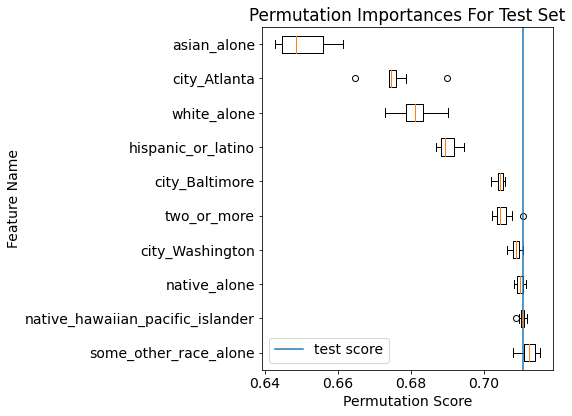

In [36]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
best_scores = sorted_indcs[0:10]
T = [feature_names[i] for i in best_scores]
print(T)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[best_scores].T,labels=T,vert=False)
plt.axvline(r2_score(y_test,y_pred),label='test score')
plt.title("Permutation Importances For Test Set")
plt.xlabel('Permutation Score')
plt.ylabel('Feature Name')
plt.legend()
plt.tight_layout()
plt.savefig("../figures/permutation_importance.png", dpi = 300, bbox_inches='tight')
plt.show()

['some_other_race_alone', 'native_hawaiian_pacific_islander', 'native_alone', 'city_Washington', 'two_or_more', 'city_Baltimore', 'hispanic_or_latino', 'white_alone', 'city_Atlanta', 'asian_alone']


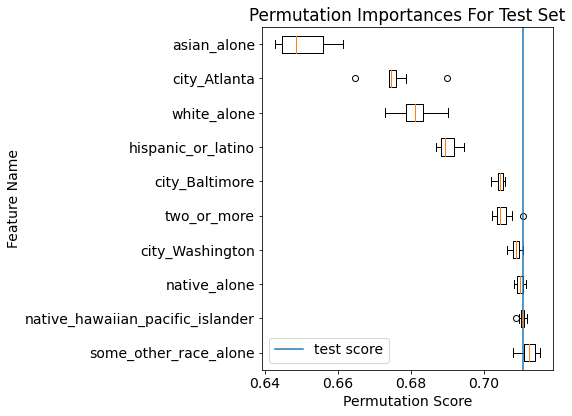

In [19]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
best_scores = sorted_indcs[0:10]
T = [feature_names[i] for i in best_scores]
print(T)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[best_scores].T,labels=T,vert=False)
plt.axvline(r2_score(y_test,y_pred),label='test score')
plt.title("Permutation Importances For Test Set")
plt.xlabel('Permutation Score')
plt.ylabel('Feature Name')
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
from matplotlib import pyplot
from xgboost import plot_importance
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

In [63]:
# plot_importance(XGB, max_num_features=10, importance_type='weight')
# plt.title('weight feature importance')
# plt.xlabel('score')
# plt.show()

In [57]:
print(XGB)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

[160874.12 332378.16 374218.6  ... 329227.28 336466.94 219325.88]
2464    169700.0
896     336800.0
2602    310700.0
2599    180400.0
7920    408900.0
          ...   
1457    107700.0
5697    400800.0
582     283100.0
855     367700.0
694     275100.0
Name: median_home_value, Length: 1271, dtype: float64


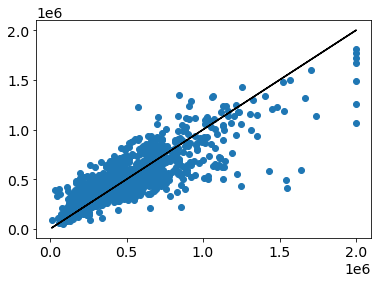

In [40]:
#scatter plot of the true vs predicted values in regression
XGB = models[1]
y_pred = XGB.predict(X_test)
print(y_pred)
print(y_test)
plt.plot(y_test,y_test,'k-', )
plt.scatter(y_test, y_pred) #predicting well? #x axis has true and y as pred
plt.savefig("../figures/ytrue_ypred_scatterplot.png", dpi = 300, bbox_inches='tight')
plt.show()